In [1]:
from pathlib import Path
from typing import Literal

import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.typing as npt
import rasterra as rt
import shapely
from shapely import wkt
import rra_tools
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from affine import Affine
from rasterio.fill import fillnodata
from scipy.signal import oaconvolve
import tqdm
import time
import os 
import PyPDF2
from PyPDF2 import PdfReader , PdfWriter, PdfMerger
from rra_tools import parallel

In [2]:
data_dir = Path("~/Desktop/Desktop/epidemiology_PhD/00_repos/wildfire_disasters_lite/data").expanduser()
plot_dir = Path("~/Desktop/Desktop/epidemiology_PhD/02_projects/wildfire-disaster/plots/").expanduser()
# list(data_dir.glob("*.parquet"))
# list(data_dir.iterdir())
mol_crs = "ESRI: 54009"

In [13]:
# read in fires
fires_conus = gpd.read_parquet(data_dir / "01_raw/all_disaster_perimeters_buffers_conus_dist_select_vars.parquet")
fires_conus_ca = fires_conus[fires_conus['aggregate_states'].str.contains("CA")]

# read in utm map
utm_map = pd.read_csv(data_dir / "utm_popden.csv")
utm_map['state_list'] = utm_map['states'].apply(lambda s: s.split(','))
utm_map = utm_map.explode('state_list').set_index('state_list')['crs'].to_dict()
utm_map = {s.strip(): f"EPSG:{crs}" for s, crs in utm_map.items()}
utm_map["PR"] = "EPSG:3920"

# read in zcta shapefile
zcta_shp = gpd.read_parquet("~/Desktop/Desktop/epidemiology_PhD/01_data/clean/us_ca_zcta_shp.parquet")
zcta_shp = gpd.GeoDataFrame(zcta_shp, geometry='geometry')


In [ ]:
# for each fire, within each zcta, how many people live within the fire perimeter (no buffer) and how many people are in each zcta? 
# dataset: fire id, zcta, affected pop count by zcta, tot pop by zcta


In [80]:
# params
area_thresh = 4046856 # 1000 acres converted to sq meters
large_fire_buffer = 20000 # meters
small_fire_buffer = 10000 # meters
pop_average_radius = 300/np.sqrt(np.pi) # radius for a circle with area 300 sq m 
pop_density_criteria = 96 # people per sq km, which is 250 people per sq mile
year = 2010

df = fires_conus_ca
df['state'] = df['aggregate_states'].apply(lambda s: s[:2])
df['year'] = df['aggregate_year'].apply(lambda y: round(y / 5)*5)
keep_cols = ['disaster_id_clean', 'year', 'state', 'shape']
row_tuples = list(df[keep_cols].itertuples(index=False, name=None))# [:5]

fire_crs = utm_map['CA']
fire_series = gpd.GeoSeries(fires_conus_ca['shape'], crs=fires_conus_ca.crs).to_crs(fire_crs)
buffer_dist = large_fire_buffer if fire_series.area.iloc[0] > area_thresh else small_fire_buffer
buffered_fire_series = fire_series.buffer(buffer_dist)
bounding_box = buffered_fire_series.envelope.buffer(pop_average_radius*1.1).to_crs(mol_crs).iloc[0]

# load pop data 
# fire_series = gpd.GeoDataFrame(fire_series, columns=['geometry'])
pop = rt.load_raster(data_dir / f"01_raw/pop_data/GHS_POP_E{year}_GLOBE_R2023A_54009_100_V1_0.tif", bounding_box.bounds)
pop = pop.to_crs(fire_crs)

# find intersect of zctas and fire series and then determine number of people in that intersection by summing across pixels contained int he intersection 

zcta_shp_fire = zcta_shp.to_crs(fire_crs)
fire_gdf = gpd.GeoDataFrame(fire_series, columns=['geometry'])
results = []

for fire_idx, fire in fire_gdf.iterrows():
    intersecting_zctas = zcta_shp_fire[zcta_shp_fire.intersects(fire.geometry)]
    for zcta_idx, zcta in intersecting_zctas.iterrows():
        intersection_geom = fire.geometry.intersection(zcta.geometry)
        results.append({
            'disaster_id': fire['disaster_id_clean'],
            'zcta': zcta['ZCTA'],
            'intersection_geom': intersection_geom
        })

# fire_zcta_intersections = gpd.GeoDataFrame(results, geometry='intersection_geom')

# fire_zcta_intersections = fire_zcta_intersections[~fire_zcta_intersections['intersection_geom'].is_empty]

# fire_zcta_intersections.head()
results

/Users/laurenwilner/opt/miniconda3/envs/wf/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


[]

/var/folders/mc/55lz7g3949x4ls_9cf39hsxc0000gn/T/ipykernel_34510/1193579151.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/mc/55lz7g3949x4ls_9cf39hsxc0000gn/T/ipykernel_34510/1193579151.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


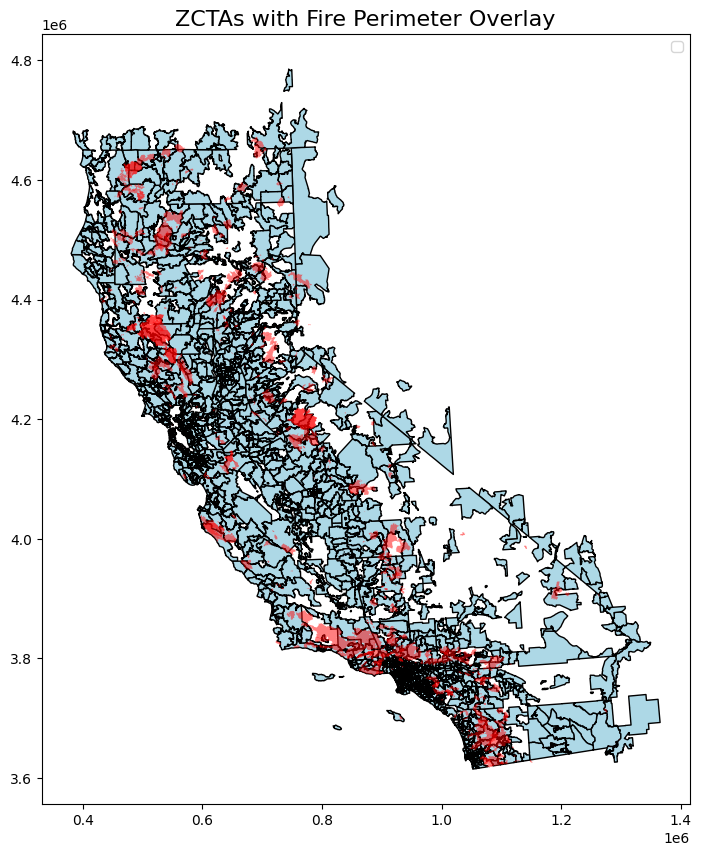

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
zcta_shp_fire.plot(ax=ax, color='lightblue', edgecolor='black', label='ZCTAs')

# Overlay the fire perimeter
fire_series.plot(ax=ax, color='red', alpha=0.5, label='Fire Perimeter')

# Set the title and display the plot
ax.set_title('ZCTAs with Fire Perimeter Overlay', fontsize=16)
ax.legend()
plt.show()

In [72]:
fire_series

4       POLYGON ((746378.406 4171476.809, 746567.311 4...
5       POLYGON ((1030836.653 4007985.977, 1030944.5 4...
6       POLYGON ((623575.173 4395380.32, 623454.955 43...
7       POLYGON ((543761.428 4629795.366, 543773.273 4...
8       POLYGON ((567258.473 4265291.202, 567394.352 4...
                              ...                        
5290    MULTIPOLYGON (((563780.302 4425519.628, 563738...
5291    POLYGON ((598685.381 4348555.457, 598750.863 4...
5315    POLYGON ((664948.259 4314562.586, 664959.165 4...
5333    MULTIPOLYGON (((567396.542 4654428.69, 567398....
5344    POLYGON ((1017215.946 3744695.79, 1017243.944 ...
Name: shape, Length: 664, dtype: geometry